In [1]:
# ===============================
# Standard Library
# ===============================
import os
import sys
import re
import ast
import csv
import shutil
import logging
from contextlib import redirect_stdout

# ===============================
# Third-Party Libraries
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from tabulate import tabulate
from scipy import stats, odr
from scipy.stats import linregress
from contextlib import contextmanager
import vcfpy  # via pip only

# ===============================
# Domain-Specific / External Libraries
# ===============================
from SigProfilerAssignment import Analyzer as Analyze  # via pip
import musical  # Not installable via pip/conda – need to clone repo

pd.set_option("display.max_columns", None)

original_sys_path = sys.path.copy()
sys.path.append(os.path.abspath(".."))
from hrdtimer import utils as HRDTimerUtils
from hrdtimer import ageEstimates as HRDTimerAgeEstimates
sys.path = original_sys_path

metadata_dir = "../data/metadata/pan_metadata_v5.csv"
metadata_df = pd.read_csv(metadata_dir)

%matplotlib inline

## Helpers

In [2]:
@contextmanager
def suppress_stdout_stderr():
    """
    A context manager that redirects stdout and stderr to devnull
    to suppress all print and error messages temporarily.
    """
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        try:
            sys.stdout = devnull
            sys.stderr = devnull
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


## Load final timing dataset and obtain test sample IDs to reproduce the analysis

In the following code snippet, we obtain 4 random samples from the PCAWG breast and SCANB cohort that were included in the main analysis and passed all our proposed QC tests, in order to showcase that the analysis is reproducible. The following code snippet allows for selecting any samples at random. However, here we will restrict to a test sample set since we have provided the corresponding vcfs in a separate folder to avoid sharing all vcfs in the current repository. 

In [3]:
timing_data = pd.read_csv("../data/output/All_data_Jun30.csv")
# Restrict to PCAWG and SCANB (remove this filter when INFORM dataset is published)
timing_data = timing_data[timing_data['cohort'].isin(['PCAWG', 'SCANB'])]
timing_data = timing_data[timing_data['removed'] == False]

sampled_pcawg = timing_data[timing_data['cohort'] == 'PCAWG'].sample(n=2, random_state=42)
sampled_scanb = timing_data[timing_data['cohort'] == 'SCANB'].sample(n=2, random_state=42)
selected_samples = pd.concat([sampled_pcawg, sampled_scanb])

test_sample_ids = selected_samples['ID'].tolist()
test_sample_ids

['f393bafe-7503-5c45-e040-11ac0d484511',
 '6c8e9197-fd16-4fed-bfda-e349cab26314',
 'PD36038a',
 'PD35930a']

In [4]:
test_sample_ids = ['f393bafe-7503-5c45-e040-11ac0d484511', '6c8e9197-fd16-4fed-bfda-e349cab26314',
                   'PD36038a','PD35930a']

The corresponding post-MutationTimeR VCF files can be found under the `../example_data/MutationTimer_vcfs` directory.

## HRDTimer Pre-Processing step:

In [5]:
MutationTimeR_vcf_dir = "../example_data/MutationTimer_vcfs"
HRDTimer_PreProcess_out_dir = "../example_data/HRDTimer_PreProcess"
metadata = "../data/metadata/pan_metadata_v5.csv"

if not os.path.exists(HRDTimer_PreProcess_out_dir):
    os.makedirs(HRDTimer_PreProcess_out_dir)

# Processing all mutations
HRDTimerUtils.process_vcfs_early_late(MutationTimeR_vcf_dir, HRDTimer_PreProcess_out_dir, metadata, time_analysis=False)
# Processing timing mutations
HRDTimerUtils.process_vcfs_early_late(MutationTimeR_vcf_dir, HRDTimer_PreProcess_out_dir, metadata, time_analysis=True)

Processing VCFs: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Since the samples selected above have passed all QC steps and are all HRD samples with a whole genome duplication, we will not need any further filtering on sample IDs. However in the general workflow, we need to make sure that we are timing samples with a WGD and characterized as HRD by HRDetect

In [6]:
# The following command generates a dict of dfs (pre-processed VCFs) for each sample with further fields that will be 
# used in the timing step.
timing_vcfs_path = "../example_data/HRDTimer_PreProcess/Breast/timing"
samples_to_time = HRDTimerUtils.prepare_samples_for_timing(timing_vcfs_path)

Processing Early samples:
Processing Files: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]
Processing Late samples:
Processing Files: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]
Processing NA samples:
Processing Files: 100%|██████████| 4/4 [00:00<00:00,  8.72it/s]


## Bootstrapping

HRDTimer uses a bootstrap resampling strategy to estimate uncertainty in mutation profiles and signature assignments.  
During this process, a temporary directory is created to store the results of each bootstrap iteration, enabling tracking of statistics across replicates (`../example_data/bootstrapping`).

For this example, memory and disk usage will be minimal.  
However, when running on the full cohort or large subcohorts, please ensure that sufficient disk space is available to store the intermediate files generated during resampling.


Since within bootstrapping, signature fitting is performed separately for the three groups of early/late/NA(undefined) mutations, within the `bootstraps` folder, and specifically within each boostrap, you can find the result of the signature fitting step as a `exposures_{time_period}.csv` file

In [7]:
output_dir = '../example_data/bootstrapping'
n_bootstraps = 200

os.makedirs(output_dir, exist_ok=True)

# Expected to take a few minutes for the small example dataset
HRDTimerUtils.generate_bootstraps(
    samples_dict=samples_to_time,
    n_bootstraps=n_bootstraps,
    output_dir=output_dir
)

Bootstrapping: 100%|██████████| 200/200 [02:21<00:00,  1.41it/s]


## HRDTimer - Timing Step

This is the HRDTimer's main function that runs both WGD and HRD time analysis. This is the most time consuming step and and is expected to take approximately 5 to 10 minutes, depending on the machine, for the example sample set (4 samples)

In [8]:
timing_results = HRDTimerUtils.run_HRD_WGD_timing_analysis(
    hrd_wgd_timing_samples=samples_to_time,
    bootstraps_dir="../example_data/bootstrapping",
)

Timing HRD: 100%|██████████| 4/4 [04:01<00:00, 60.41s/it]


### Display the results

In [9]:
timing_results.head()

,ID,HRDTime,HRDTime_ci_hi,HRDTime_ci_lo,HRDTime_ci_IQR_hi,HRDTime_ci_IQR_lo,WGDTime,WGDTime_ci_hi,WGDTime_ci_lo,WGDTime_ci_IQR_hi,WGDTime_ci_IQR_lo,WGDTime_CpG,pi2SBS1,pi2SBS1_ci,pi2SBS3,pi2SBS3_ci,pi1SBS1,pi1SBS1_ci,pi1SBS3,pi1SBS3_ci,c,c21,Nt_SBS1,Nt_SBS3,N_mut(C>TpG),N_mut_all
0,f393bafe-7503-5c45-e040-11ac0d484511,0.187921,0.120848,0.125087,0.047517,0.043191,0.720341,0.038979,0.031916,0.013132,0.013085,0.651642,"[0.4869041999552381, 0.35978813560168904, 0.48...","[0.046413634366883644, 0.05489254059510795, 0....","[0.40573543424077224, 0.24045978696270523, 0.4...","[0.057442689653286555, 0.04697011142552618, 0....","[0.4852999928461202, 0.5948569779550755, 0.465...","[0.04359400274718714, 0.0504791482454055, 0.03...","[0.5469785696422823, 0.7059068576988818, 0.532...","[0.052067538584364664, 0.04274254323098986, 0....","[0.08279097148520172, 0, 0.0695603223338267]",0.071969,"[31.80821804989356, 60.41799942300642, 120.793...","[343.5324996491304, 880.7903453488022, 1529.87...","[46, 97, 179]","[858, 2223, 3855]"
1,PD36038a,0.274367,0.079853,0.095659,0.032008,0.028196,0.568271,0.037024,0.039037,0.012712,0.010711,0.565208,"[0.3179834861336084, 0.2532634281737704, 0.362...","[0.03892303708600334, 0.03194905633850345, 0.0...","[0.20968001385496496, 0.1393625435892164, 0.26...","[0.055543912440090645, 0.033108364321198576, 0...","[0.6575414198814378, 0.7198068425298562, 0.619...","[0.037089173754910165, 0.030258595798797416, 0...","[0.7459784437052209, 0.8121486906780331, 0.699...","[0.052115434997764776, 0.03083340926008532, 0....","[0.07286407684020134, 0, 0.05247226451053597]",0.069622,"[68.04450286812745, 94.51055842058992, 8.89792...","[831.2856324893396, 1114.0131453105516, 151.60...","[80, 108, 10]","[1444, 1843, 273]"
2,6c8e9197-fd16-4fed-bfda-e349cab26314,0.418852,0.103917,0.121651,0.037698,0.032345,0.830014,0.031709,0.028331,0.009204,0.009708,0.820245,"[0.6526126482899977, 0.4278892752148755, 0.683...","[0.04683377095307617, 0.07781372109216919, 0.0...","[0.5030036392475007, 0.26459461378298876, 0.50...","[0.0653277165537593, 0.07081444494470288, 0.06...","[0.33375240815683005, 0.5415754820675613, 0.30...","[0.04468948778662496, 0.07130044086126552, 0.0...","[0.4597759078528576, 0.692959222876729, 0.4584...","[0.060122586346500945, 0.0659972963712353, 0.0...","[0.07716225220945679, 0, 0.06441832122250435]",0.067408,"[44.58142404507316, 36.14195093737767, 139.986...","[423.00612851669945, 414.0139000829789, 1434.8...","[62, 51, 186]","[1076, 1004, 3510]"
3,PD35930a,0.397768,0.110566,0.123075,0.035348,0.040705,0.913149,0.029843,0.026812,0.009503,0.010755,0.835447,"[0.7513525478925824, 0.4765818741487755, 0.810...","[0.05193255610653663, 0.0650815017448445, 0.03...","[0.679995359208155, 0.3695088904354057, 0.6477...","[0.056431367473200544, 0.06663307562830231, 0....","[0.22679705749205287, 0.4886902470693703, 0.18...","[0.047224082087012995, 0.060786194414330585, 0...","[0.29025226233048534, 0.5963528793184973, 0.32...","[0.05088290408553624, 0.06241519138157747, 0.0...","[0.05442448564421323, 0, 0.05126167296226312]",0.053194,"[69.4576120666237, 49.00095843882153, 56.92368...","[1002.5635818618117, 477.71605821944803, 639.8...","[99, 71, 79]","[2498, 1180, 1591]"


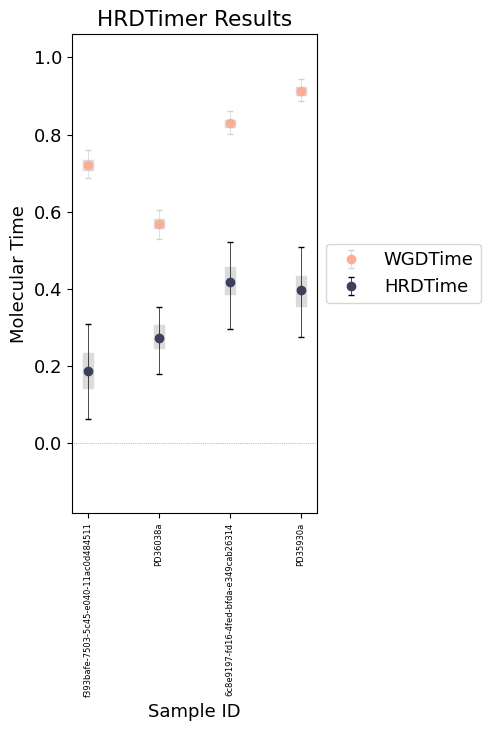

In [10]:
plt.figure(figsize=(6, 7.5))

for i, row in timing_results.iterrows():
    plt.errorbar(
        i, row['WGDTime'],
        yerr=[[row['WGDTime_ci_lo']], [row['WGDTime_ci_hi']]],
        fmt='o', color='#fcad97', ecolor='lightgrey', elinewidth=0.5,
        capsize=2, markersize=6, label='WGDTime' if i == 0 else ""
    )
    plt.errorbar(
        i, row['HRDTime'],
        yerr=[[row['HRDTime_ci_lo']], [row['HRDTime_ci_hi']]],
        fmt='o', color='#3d405b', ecolor='k', elinewidth=0.5,
        capsize=2, markersize=6, label='HRDTime' if i == 0 else "", zorder=3
    )
    plt.fill_between(
        [i - 0.07, i + 0.07],
        [row['HRDTime'] - row['HRDTime_ci_IQR_lo']] * 2,
        [row['HRDTime'] + row['HRDTime_ci_IQR_hi']] * 2,
        color='#dbdbdb', alpha=1, zorder=0
    )
    plt.fill_between(
        [i - 0.07, i + 0.07],
        [row['WGDTime'] - row['WGDTime_ci_IQR_lo']] * 2,
        [row['WGDTime'] + row['WGDTime_ci_IQR_hi']] * 2,
        color='#dbdbdb', alpha=1, zorder=0
    )

plt.xticks(range(len(timing_results)), timing_results['ID'], rotation=90, fontsize=6)
plt.ylim(-0.18, 1.06)
plt.ylabel("Molecular Time")
plt.xlabel("Sample ID")
plt.title("HRDTimer Results")
plt.axhline(y=0, color='grey', linestyle=':', linewidth=0.5)

# Move legend outside
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right
plt.show()

## Molecular Time to Age

To translate molecular time to age, we first need to estimate what is the SBS1 burden for each sample at the time the sample was sequenced (capturing the MRCA burden). To do so, we will need to load all the mutations per sample, from the pre-processed output, as follows:

In [11]:
all_mutations_dir = "../example_data/HRDTimer_PreProcess/Breast/all_mut"
timing_mutations_dir = "../example_data/HRDTimer_PreProcess/Breast/timing"

with suppress_stdout_stderr():
    HRDTimerUtils.run_Signature_Analysis(all_mutations_dir, genome_build="GRCh37")
    HRDTimerUtils.run_Signature_Analysis(timing_mutations_dir, genome_build="GRCh37")


In [12]:
all_mutations_dir = "../example_data/HRDTimer_PreProcess/Breast/all_mut"
samples_to_time_all_mut = HRDTimerUtils.prepare_samples_for_timing(all_mutations_dir)

Processing Early samples:
Processing Files: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]
Processing Late samples:
Processing Files: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]
Processing NA samples:
Processing Files: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


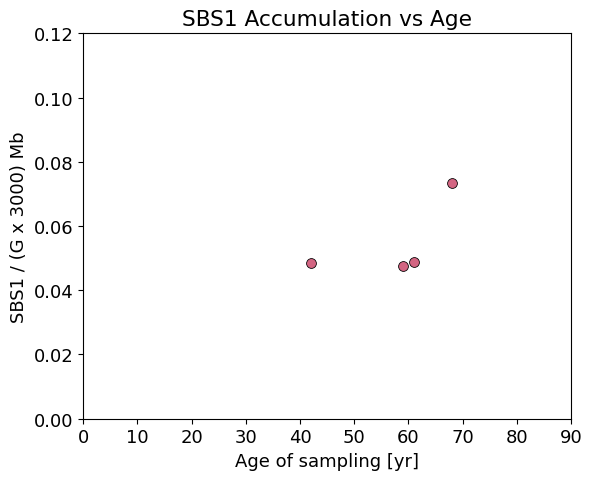

In [13]:
# Calculate genome sizes
G_values = {sample_id: HRDTimerUtils.G(df) for sample_id, df in samples_to_time_all_mut.items()}
G_df = pd.DataFrame.from_dict(G_values, orient='index', columns=['G']).reset_index()
G_df.rename(columns={'index': 'ID'}, inplace=True)

exposures_df = HRDTimerUtils.get_signature_exposures(samples_to_time_all_mut)
exposures_t = exposures_df.T.reset_index().rename(columns={'index': 'ID'})
exposures_t = exposures_t[['ID', 'SBS1']]
exposures_t = exposures_t.merge(G_df, on='ID', how='left')

# Merge metadata (sample, age, and type)
exposures_t = exposures_t.merge(metadata_df[['sample', 'age', 'type']], left_on='ID', right_on='sample', how='left')
exposures_t.drop(columns=['sample'], inplace=True)  # optional

exposures_t['scaled_SBS1'] = exposures_t['SBS1'] / (exposures_t['G'] * 3000)

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(data=exposures_t, x='age', y='scaled_SBS1', alpha=1, color='#D36582', edgecolors='black', s=50)
plt.ylim(0, 0.12)
plt.xlim(0, 90)
plt.xlabel("Age of sampling [yr]")
plt.ylabel("SBS1 / (G x 3000) Mb")
plt.title("SBS1 Accumulation vs Age")
plt.tight_layout()
plt.show()


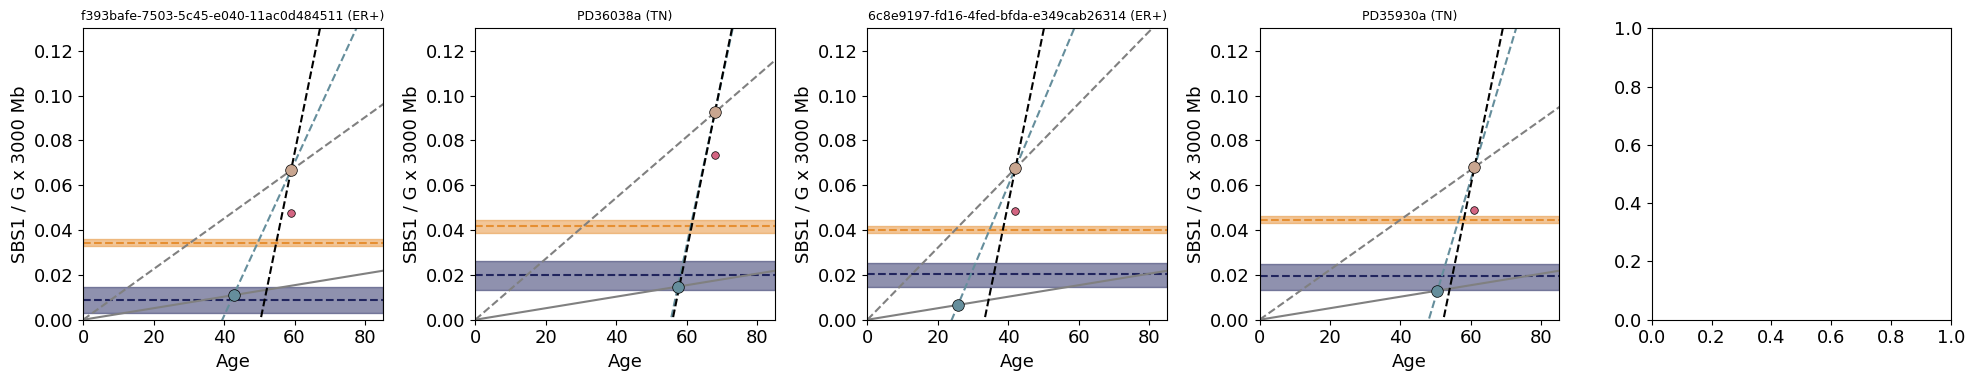

In [14]:
# The late SBS1 burden is estimated from scNanoSeq data 
# and is divided by 2 * 3000 Mb to scale it appropriately.

age_estimates = HRDTimerAgeEstimates.MolecularTime_to_Age(exposures_t, 
                                                          timing_results,
                                                          metadata_df,
                                                          late_SBS1_burden=0.0191667)

In [15]:
age_estimates

,ID,Age,HRD_linear,HRD_linear_low,HRD_linear_high,WGD_linear,WGD_linear_low,WGD_linear_high,HRD_norm_int,HRD_norm_int_low,HRD_norm_int_high,WGD_norm_int,WGD_norm_int_low,WGD_norm_int_high,HRD_norm_max,HRD_norm_max_low,HRD_norm_max_high,WGD_norm_max,WGD_norm_max_low,WGD_norm_max_high
0,f393bafe-7503-5c45-e040-11ac0d484511,59.0,7.898279,2.640905,12.977499,30.275812,28.934398,31.914110,34.724030,11.610485,43.779782,49.500551,49.056928,50.042357,34.724030,11.610485,52.255549,54.790562,54.593982,55.030649
1,PD36038a,68.0,14.791421,9.634314,19.096400,30.636108,28.531600,32.632124,58.222727,51.018434,59.013783,61.134247,60.747536,61.501022,58.607813,51.018434,59.367712,61.404660,61.033180,61.756990
2,6c8e9197-fd16-4fed-bfda-e349cab26314,42.0,12.599705,8.940256,15.725686,24.968062,24.115818,25.921908,29.353694,27.779611,30.698311,34.673846,34.307260,35.084135,35.865315,35.101732,36.517584,38.446104,38.268275,38.645135
3,PD35930a,61.0,17.428426,12.035820,22.272919,40.010104,38.835331,41.317690,51.732883,50.585945,52.763245,56.535717,56.285858,56.813824,54.694361,52.254387,55.395452,57.962361,57.792349,58.151594
